In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display

import IPython.display

In [106]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata['length'] = metadata['end']-metadata['start']
metadata.info()
display(metadata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   length           8732 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 614.1+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class,length
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,4.000000
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,4.000000
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,4.000000
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,4.000000
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,2.532098


In [4]:
# Simple way to have a dict relating classID to class
class_dict = {}
for index, row in metadata.iterrows():
    class_dict[row['classID']]=row['class']
print(class_dict)
print(f'Number of unique classes: {len(class_dict)}')

{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
Number of unique classes: 10


In [5]:
# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename)

slice_file_name    122690-6-0-0.wav
fsID                         122690
start                     12.231953
end                        15.37784
salience                          1
fold                              1
classID                           6
class                      gun_shot
length                     3.145887
Name: 1000, dtype: object
(69367,)
(257, 542)


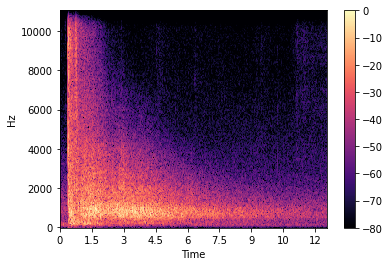

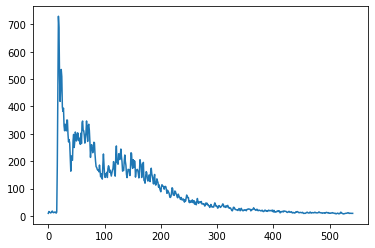

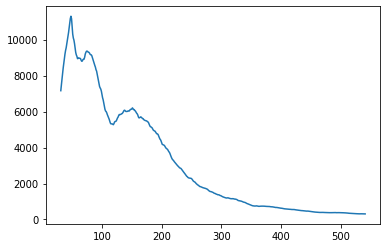

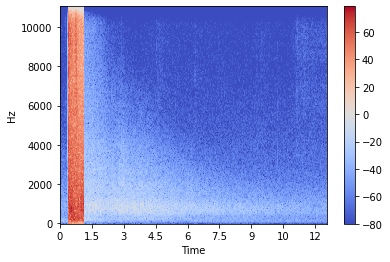

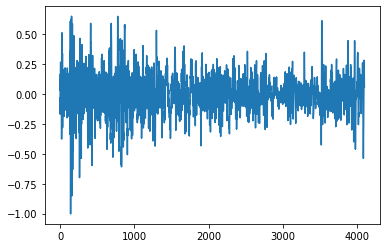

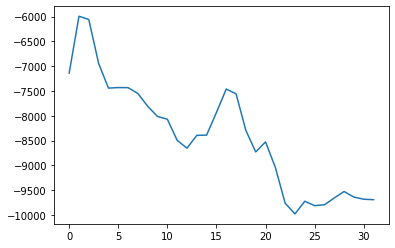

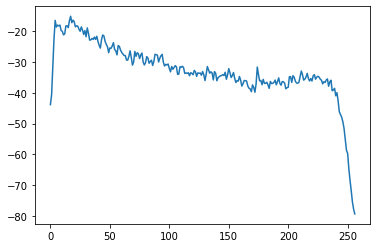

In [192]:
n_fft = 512
hop_length = n_fft//4
freq_min = 0
freq_max = 9999 #25
rolling_length = 32

# Pick a row to visualize the datum
row_ind = 1000
row = metadata.loc[row_ind]
print(row)
y, sr = load_data(row)
print(y.shape)
ySF = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
S_db = librosa.amplitude_to_db(ySF, ref=np.max) # Converting to decibell is effectively just a logarithmic transform
print(S_db.shape)

#librosa.display.specshow(S_db[:,:], x_axis='time', y_axis='linear', sr=sr, n_fft=n_fft, hop_length=hop_length)
librosa.display.specshow(S_db[:,:], x_axis='time', y_axis='linear', sr=sr)
plt.colorbar()
plt.show()

power = np.sum(ySF[freq_min:freq_max,:],axis=0)
plt.plot(power)
plt.show()

power_rolling = pd.Series(power).rolling(rolling_length, center=False).sum()
plt.plot(power_rolling)
plt.show()
#print(power_rolling)

best_window_ind = np.argmax(power_rolling)
S_db_highlight = S_db.copy()
S_db_highlight[:,(best_window_ind-rolling_length+1):(best_window_ind+1)]+=80
librosa.display.specshow(S_db_highlight, x_axis='time', y_axis='linear', sr=sr)
plt.colorbar()
plt.show()

# print(best_window_ind)

y_window = y[((best_window_ind-rolling_length+1)*hop_length):((best_window_ind+1)*hop_length)]
plt.plot(y_window)
plt.show()

features_window = S_db[:,(best_window_ind-rolling_length+1):(best_window_ind+1)]
features0 = np.sum(features_window, axis=0)
features1 = np.sum(features_window, axis=1)/rolling_length
plt.plot(features0)
plt.show()
plt.plot(features1)
plt.show()


max_amp = max(abs(y))
display(IPython.display.Audio(data=y/(max_amp*10), rate=sr, normalize=False))
display(IPython.display.Audio(data=y_window/(max_amp*10), rate=sr, normalize=False))
